# Assignment 3: DTMF Detection and Graph Signal Processing

This notebook contains the complete solution for Assignment 3, including:
- Question 1: DTMF signal detection using clustering and changepoint detection
- Question 2: Test set prediction
- Question 3: Graph wavelet filter bank design
- Question 4-7: Graph signal processing on meteorological data

# Setup

**Imports**

In [1]:
import datetime as dt
from math import log, asin, cos, radians, sin, sqrt
import re
import IPython
import geopandas
import contextily as cx
import networkx as nx
import pandas as pd
import geopandas as gpd

from loadmydata.load_molene_meteo import load_molene_meteo_dataset
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import ruptures as rpt
from scipy.fft import fft
from scipy.signal import stft, butter, filtfilt, hilbert, find_peaks
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from pygsp import graphs
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans

rng = np.random.default_rng()

# Question 1: DTMF Detection using Unsupervised Clustering

The following cell loads the training data set `X_train` and `y_train`.
`X_train` is a list of 100 signals; `y_train` is a list of 100 symbol sequences. 

The signals have a varying number of symbols with a varying duration. 
There is a brief silence between each symbol.
The sampling frequency is $22.05$ kHz.

We implement a complete unsupervised pipeline:
1. STFT and energy computation
2. Signal/noise separation using K-means (k=2)
3. Hierarchical frequency clustering with elbow method
4. Changepoint detection per frequency cluster
5. Interval ranking and symbol pairing

In [2]:
FS = 22050  # sampling frequency (Hz)

X_train = np.load("X_train.npy", allow_pickle=True).tolist()
y_train = np.load("y_train.npy", allow_pickle=True).tolist()

STFT shape: (451, 45)
Energy per frequency shape: (451,)
Frequency bins: 451, Time frames: 45


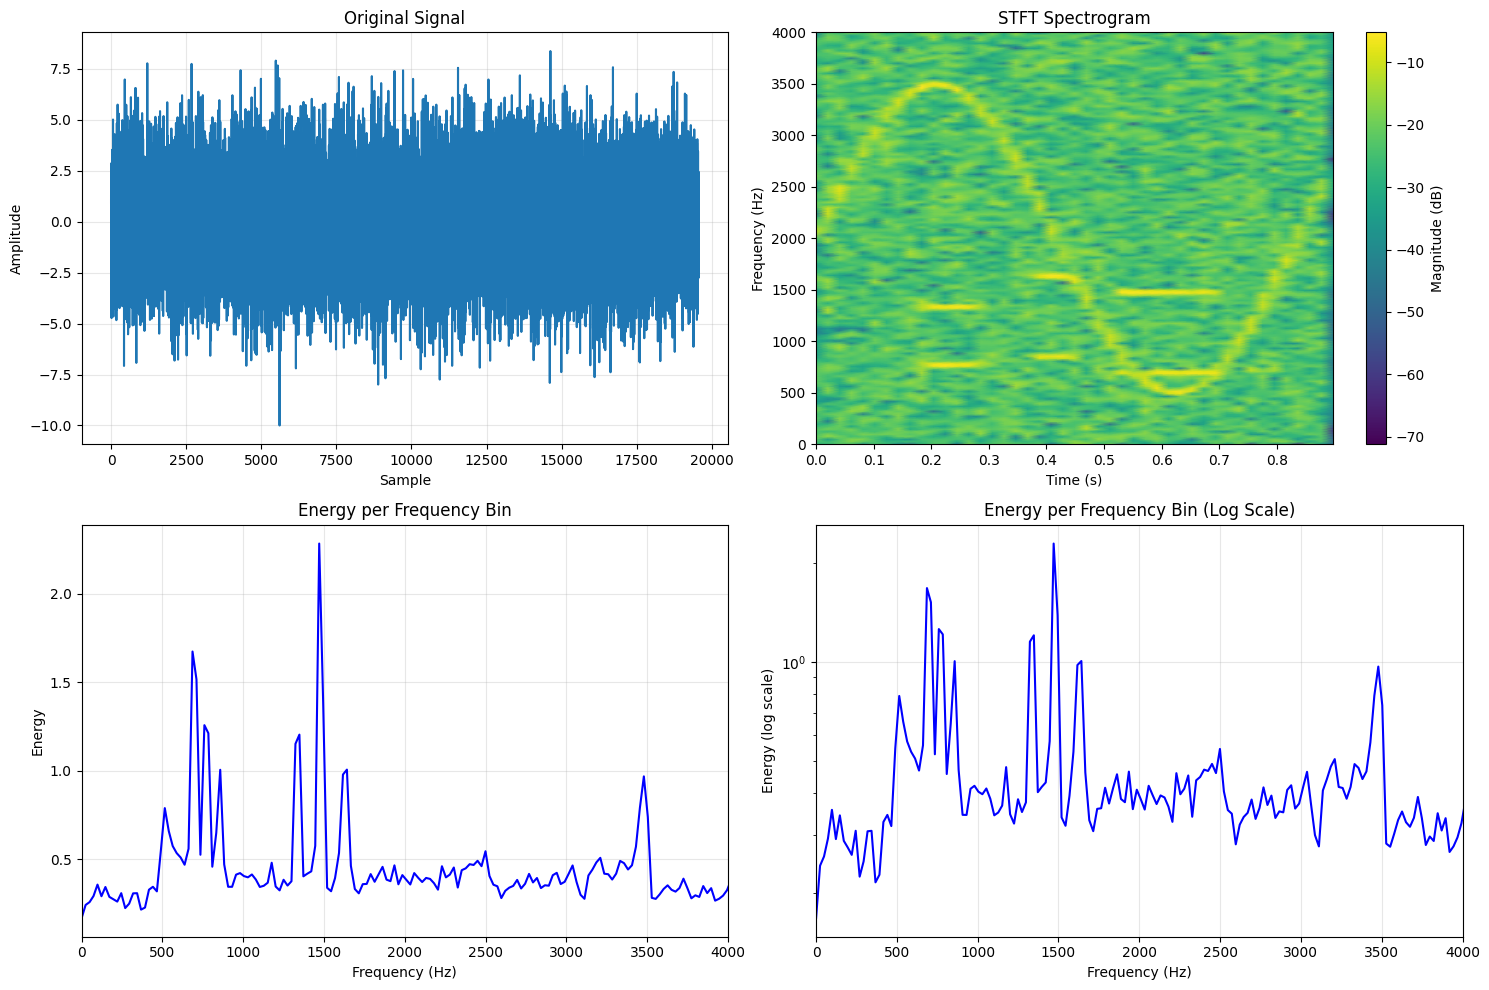

In [3]:
# Cell 1: STFT and energy computation
# we compute the STFT to obtain the time-frequency representation
# for each frequency bin, we compute the energy by integrating over the time axis

signal = X_train[0]  # example signal
window_length = 900
overlap = window_length // 2

# compute STFT
f, t, Zxx = stft(signal, fs=FS, nperseg=window_length, noverlap=overlap)

# compute energy for each frequency bin by integrating over time
energy_per_freq = np.sum(np.abs(Zxx)**2, axis=1)  # shape: (n_freq,)

print(f"STFT shape: {Zxx.shape}")
print(f"Energy per frequency shape: {energy_per_freq.shape}")
print(f"Frequency bins: {len(f)}, Time frames: {len(t)}")

# visualization: STFT spectrogram and energy distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# plot 1: original signal
axes[0, 0].plot(signal)
axes[0, 0].set_title("Original Signal")
axes[0, 0].set_xlabel("Sample")
axes[0, 0].set_ylabel("Amplitude")
axes[0, 0].grid(True, alpha=0.3)

# plot 2: STFT spectrogram
spectrogram = np.abs(Zxx)
im1 = axes[0, 1].pcolormesh(t, f, 20 * np.log10(spectrogram + 1e-10), 
                            shading='gouraud', cmap='viridis')
axes[0, 1].set_title("STFT Spectrogram")
axes[0, 1].set_xlabel("Time (s)")
axes[0, 1].set_ylabel("Frequency (Hz)")
axes[0, 1].set_ylim([0, 4000])  # focus on DTMF frequency range
plt.colorbar(im1, ax=axes[0, 1], label="Magnitude (dB)")

# plot 3: energy per frequency bin
axes[1, 0].plot(f, energy_per_freq, 'b-', linewidth=1.5)
axes[1, 0].set_title("Energy per Frequency Bin")
axes[1, 0].set_xlabel("Frequency (Hz)")
axes[1, 0].set_ylabel("Energy")
axes[1, 0].set_xlim([0, 4000])
axes[1, 0].grid(True, alpha=0.3)

# plot 4: energy per frequency (log scale)
axes[1, 1].semilogy(f, energy_per_freq, 'b-', linewidth=1.5)
axes[1, 1].set_title("Energy per Frequency Bin (Log Scale)")
axes[1, 1].set_xlabel("Frequency (Hz)")
axes[1, 1].set_ylabel("Energy (log scale)")
axes[1, 1].set_xlim([0, 4000])
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Total frequency bins: 451
High-energy (signal) bins: 12
Noise bins: 439
Signal cluster center energy: 1.30e+00
Noise cluster center energy: 3.30e-01


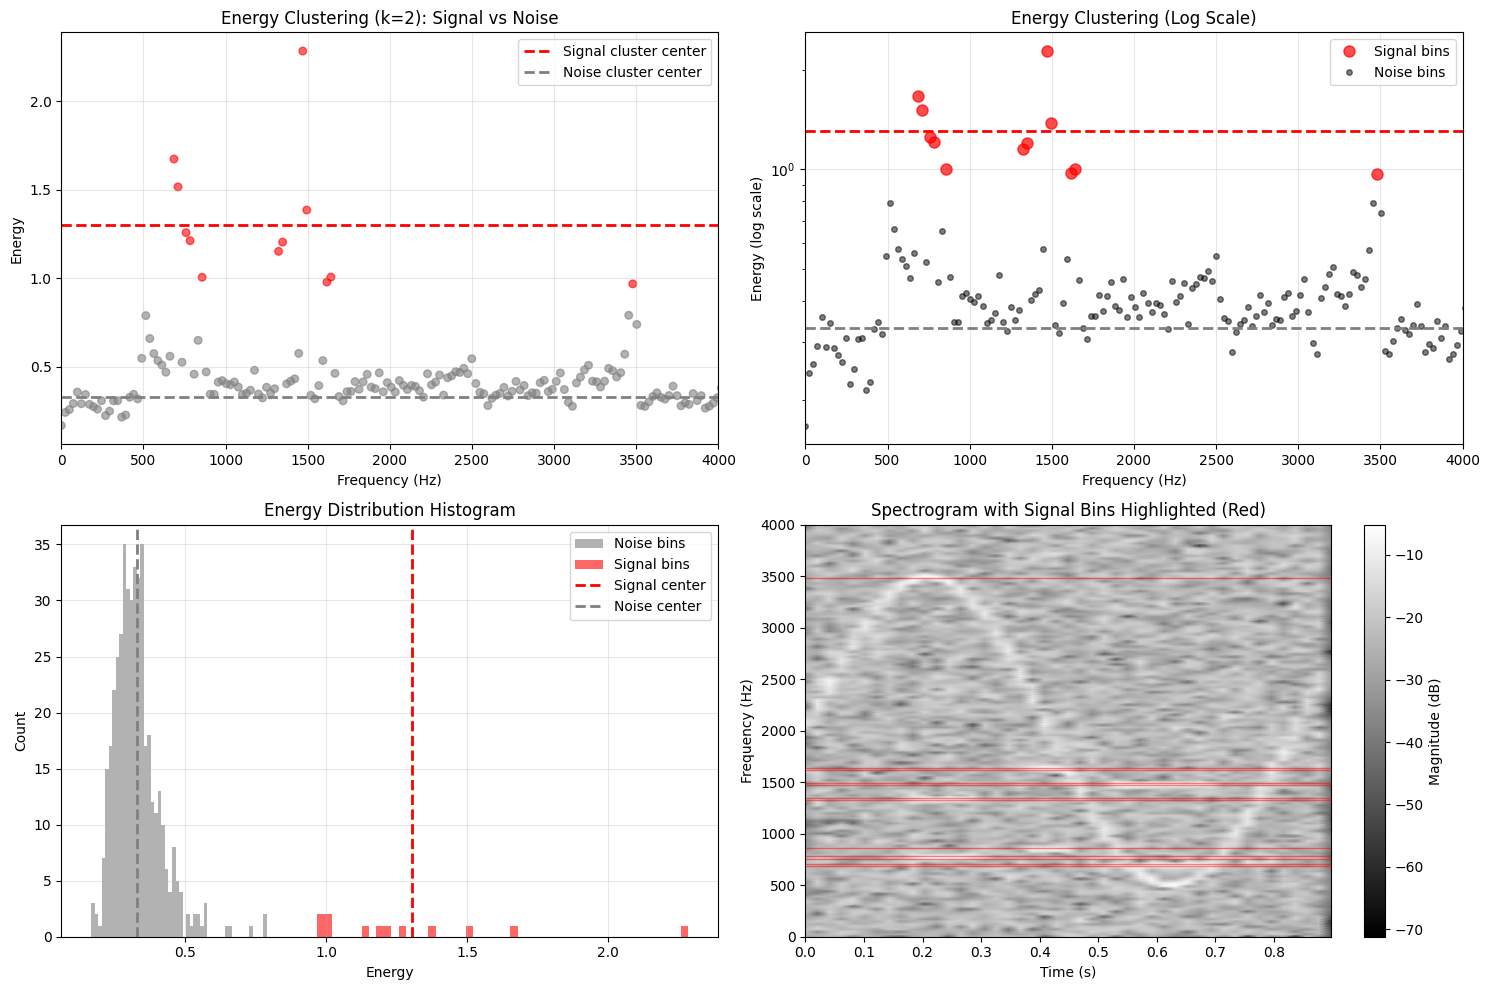

In [4]:
# Cell 2: First k-means (k=2) to separate signal from noise
# we perform k-means clustering on the energy values to separate frequency bins 
# with high energy (signal) from those with low energy (noise)

# reshape energy for k-means
energy_reshaped = energy_per_freq.reshape(-1, 1)

# k-means with k=2 to separate signal from noise
kmeans_energy = KMeans(n_clusters=2, random_state=0, n_init=10)
energy_labels = kmeans_energy.fit_predict(energy_reshaped)

# identify which cluster has higher energy (signal cluster)
cluster_centers = kmeans_energy.cluster_centers_.flatten()
signal_cluster_idx = np.argmax(cluster_centers)
noise_cluster_idx = 1 - signal_cluster_idx

# get frequency bins that belong to signal cluster
high_energy_freq_indices = np.where(energy_labels == signal_cluster_idx)[0]
high_energy_freqs = f[high_energy_freq_indices]

print(f"Total frequency bins: {len(f)}")
print(f"High-energy (signal) bins: {len(high_energy_freq_indices)}")
print(f"Noise bins: {len(f) - len(high_energy_freq_indices)}")
print(f"Signal cluster center energy: {cluster_centers[signal_cluster_idx]:.2e}")
print(f"Noise cluster center energy: {cluster_centers[noise_cluster_idx]:.2e}")

# visualization: energy clustering results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# plot 1: energy distribution with cluster assignment
colors = ['red' if label == signal_cluster_idx else 'gray' 
          for label in energy_labels]
axes[0, 0].scatter(f, energy_per_freq, c=colors, alpha=0.6, s=30)
axes[0, 0].axhline(y=cluster_centers[signal_cluster_idx], 
                   color='red', linestyle='--', linewidth=2, label='Signal cluster center')
axes[0, 0].axhline(y=cluster_centers[noise_cluster_idx], 
                   color='gray', linestyle='--', linewidth=2, label='Noise cluster center')
axes[0, 0].set_title("Energy Clustering (k=2): Signal vs Noise")
axes[0, 0].set_xlabel("Frequency (Hz)")
axes[0, 0].set_ylabel("Energy")
axes[0, 0].set_xlim([0, 4000])
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# plot 2: energy distribution (log scale) with clusters
axes[0, 1].semilogy(f[energy_labels == signal_cluster_idx], 
                    energy_per_freq[energy_labels == signal_cluster_idx], 
                    'ro', markersize=8, alpha=0.7, label='Signal bins')
axes[0, 1].semilogy(f[energy_labels == noise_cluster_idx], 
                    energy_per_freq[energy_labels == noise_cluster_idx], 
                    'ko', markersize=4, alpha=0.5, label='Noise bins')
axes[0, 1].axhline(y=cluster_centers[signal_cluster_idx], 
                   color='red', linestyle='--', linewidth=2)
axes[0, 1].axhline(y=cluster_centers[noise_cluster_idx], 
                   color='gray', linestyle='--', linewidth=2)
axes[0, 1].set_title("Energy Clustering (Log Scale)")
axes[0, 1].set_xlabel("Frequency (Hz)")
axes[0, 1].set_ylabel("Energy (log scale)")
axes[0, 1].set_xlim([0, 4000])
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# plot 3: histogram of energy values with cluster centers
axes[1, 0].hist(energy_per_freq[energy_labels == noise_cluster_idx], 
                bins=50, alpha=0.6, color='gray', label='Noise bins')
axes[1, 0].hist(energy_per_freq[energy_labels == signal_cluster_idx], 
                bins=50, alpha=0.6, color='red', label='Signal bins')
axes[1, 0].axvline(x=cluster_centers[signal_cluster_idx], 
                   color='red', linestyle='--', linewidth=2, label='Signal center')
axes[1, 0].axvline(x=cluster_centers[noise_cluster_idx], 
                   color='gray', linestyle='--', linewidth=2, label='Noise center')
axes[1, 0].set_title("Energy Distribution Histogram")
axes[1, 0].set_xlabel("Energy")
axes[1, 0].set_ylabel("Count")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# plot 4: spectrogram highlighting signal vs noise bins
spectrogram = np.abs(Zxx)
im = axes[1, 1].pcolormesh(t, f, 20 * np.log10(spectrogram + 1e-10), 
                           shading='gouraud', cmap='gray')
# highlight signal bins
for idx in high_energy_freq_indices:
    axes[1, 1].axhline(y=f[idx], color='red', linewidth=1, alpha=0.5)
axes[1, 1].set_title("Spectrogram with Signal Bins Highlighted (Red)")
axes[1, 1].set_xlabel("Time (s)")
axes[1, 1].set_ylabel("Frequency (Hz)")
axes[1, 1].set_ylim([0, 4000])
plt.colorbar(im, ax=axes[1, 1], label="Magnitude (dB)")

plt.tight_layout()
plt.show()


Hierarchical split uses band-limited bins: n=11 (from total 12)

Coarse split (k=2) centers (in-band): [1482.2, 759.5] Hz
Low group: n=5, mean=759.5 Hz
High group: n=6, mean=1482.2 Hz


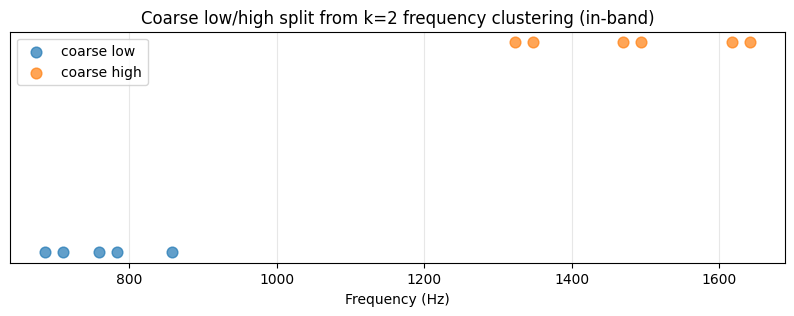


Hierarchical elbow inside groups
Low group: n=5, k_low=3
High group: n=6, k_high=3


/tmp/ipykernel_284394/2668330018.py:31: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dist = abs(np.cross(v, p - p1)) / v_norm
/tmp/ipykernel_284394/2668330018.py:31: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dist = abs(np.cross(v, p - p1)) / v_norm


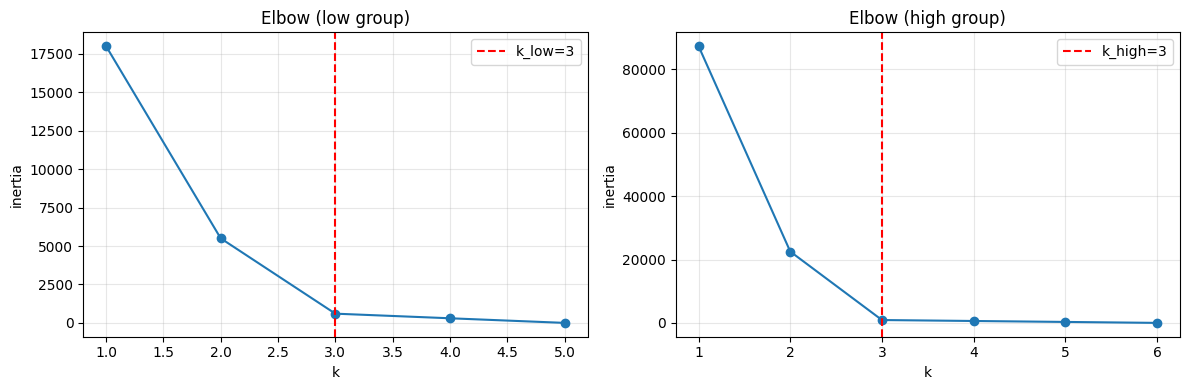

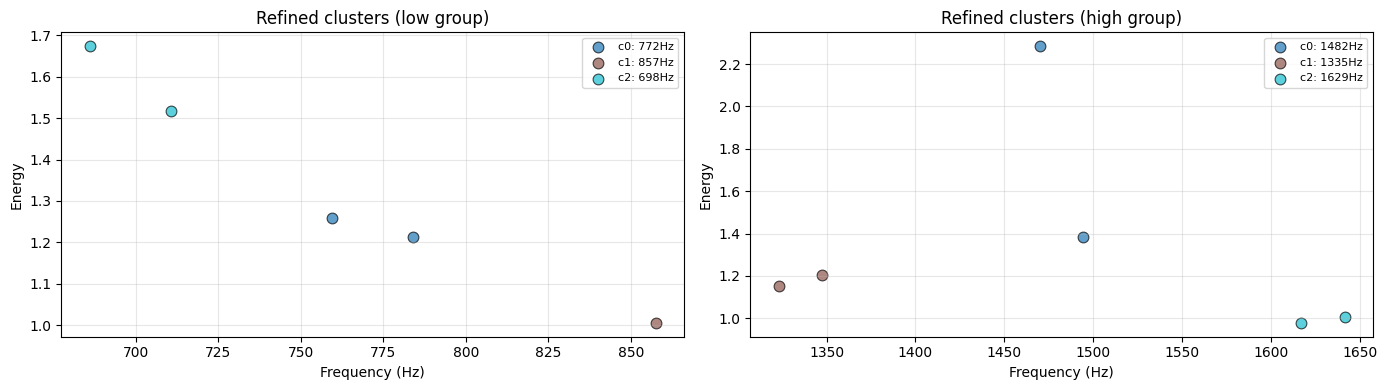


Refined clusters after low/high elbow: 6
Cluster 0: band=low, center=698.2 Hz, n_bins=2
Cluster 1: band=low, center=771.7 Hz, n_bins=2
Cluster 2: band=low, center=857.5 Hz, n_bins=1
Cluster 3: band=high, center=1335.2 Hz, n_bins=2
Cluster 4: band=high, center=1482.2 Hz, n_bins=2
Cluster 5: band=high, center=1629.2 Hz, n_bins=2


In [5]:
# Cell 3: Hierarchical elbow clustering
# we do a coarse k=2 split in frequency, then apply elbow method within each group

def elbow_kmeans_1d(freqs_1d, k_max=12, random_state=0, n_init=10):
    """we perform elbow method on 1d frequencies"""
    freqs_1d = np.asarray(freqs_1d, dtype=float).reshape(-1, 1)
    n = int(freqs_1d.shape[0])
    if n < 2:
        return 0, None, [], []
    k_max_eff = int(min(max(1, k_max), n))
    k_candidates = list(range(1, k_max_eff + 1))
    inertias = []
    for k in k_candidates:
        km = KMeans(n_clusters=k, random_state=int(random_state), n_init=int(n_init))
        km.fit(freqs_1d)
        inertias.append(float(km.inertia_))
    if len(inertias) == 1:
        k_opt = 1
    else:
        ks = np.array(k_candidates, dtype=float)
        ys = np.array(inertias, dtype=float)
        ks_n = (ks - ks.min()) / (ks.max() - ks.min() + 1e-12)
        ys_n = (ys - ys.min()) / (ys.max() - ys.min() + 1e-12)
        p1 = np.array([ks_n[0], ys_n[0]])
        p2 = np.array([ks_n[-1], ys_n[-1]])
        v = p2 - p1
        v_norm = np.linalg.norm(v) + 1e-12
        distances = []
        for xi, yi in zip(ks_n, ys_n):
            p = np.array([xi, yi])
            dist = abs(np.cross(v, p - p1)) / v_norm
            distances.append(float(dist))
        k_opt = int(k_candidates[int(np.argmax(distances))])
    km_final = KMeans(n_clusters=int(k_opt), random_state=int(random_state), n_init=int(n_init))
    labels = km_final.fit_predict(freqs_1d)
    return int(k_opt), labels, k_candidates, inertias

# we take the high-energy bins from cell 2
high_energy_freqs_all = f[high_energy_freq_indices]
high_energy_energies_all = energy_per_freq[high_energy_freq_indices]
n_high_energy_all = len(high_energy_freq_indices)

# we restrict the hierarchical split to a wide DTMF band to avoid outliers
dtmf_freq_range = (400.0, 2000.0)
band_mask = (high_energy_freqs_all >= dtmf_freq_range[0]) & (high_energy_freqs_all <= dtmf_freq_range[1])

high_energy_freqs = high_energy_freqs_all[band_mask]
high_energy_energies = high_energy_energies_all[band_mask]
high_energy_indices = high_energy_freq_indices[band_mask]
n_high_energy = len(high_energy_indices)

print(f"\nHierarchical split uses band-limited bins: n={n_high_energy} (from total {n_high_energy_all})")

if n_high_energy < 2:
    print(f"Warning: only {n_high_energy} in-band bins; skipping hierarchical clustering")
    major_freq_clusters = []
else:
    # coarse split: k=2 on in-band frequency only
    km_2 = KMeans(n_clusters=2, random_state=0, n_init=10)
    coarse_labels = km_2.fit_predict(high_energy_freqs.reshape(-1, 1))
    coarse_centers = km_2.cluster_centers_.flatten()
    low_coarse_id = int(np.argmin(coarse_centers))
    high_coarse_id = int(np.argmax(coarse_centers))

    low_mask = coarse_labels == low_coarse_id
    high_mask = coarse_labels == high_coarse_id

    low_freqs = high_energy_freqs[low_mask]
    low_energies = high_energy_energies[low_mask]
    low_indices = high_energy_indices[low_mask]

    high_freqs = high_energy_freqs[high_mask]
    high_energies = high_energy_energies[high_mask]
    high_indices = high_energy_indices[high_mask]

    print(f"\nCoarse split (k=2) centers (in-band): {np.round(coarse_centers, 1).tolist()} Hz")
    print(f"Low group: n={len(low_freqs)}, mean={float(np.mean(low_freqs)) if len(low_freqs) else float('nan'):.1f} Hz")
    print(f"High group: n={len(high_freqs)}, mean={float(np.mean(high_freqs)) if len(high_freqs) else float('nan'):.1f} Hz")

    plt.figure(figsize=(10, 3))
    plt.scatter(low_freqs, np.zeros_like(low_freqs), s=60, alpha=0.7, label='coarse low')
    plt.scatter(high_freqs, np.zeros_like(high_freqs) + 0.05, s=60, alpha=0.7, label='coarse high')
    plt.yticks([])
    plt.xlabel('Frequency (Hz)')
    plt.title('Coarse low/high split from k=2 frequency clustering (in-band)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    k_low, low_labels, low_k_candidates, low_inertias = elbow_kmeans_1d(low_freqs, k_max=8)
    k_high, high_labels, high_k_candidates, high_inertias = elbow_kmeans_1d(high_freqs, k_max=8)

    print(f"\nHierarchical elbow inside groups")
    print(f"Low group: n={len(low_freqs)}, k_low={k_low}")
    print(f"High group: n={len(high_freqs)}, k_high={k_high}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    if len(low_inertias) > 0:
        axes[0].plot(low_k_candidates, low_inertias, marker='o')
        axes[0].axvline(k_low, color='red', linestyle='--', label=f'k_low={k_low}')
        axes[0].set_title('Elbow (low group)')
        axes[0].set_xlabel('k')
        axes[0].set_ylabel('inertia')
        axes[0].grid(True, alpha=0.3)
        axes[0].legend()
    else:
        axes[0].axis('off')

    if len(high_inertias) > 0:
        axes[1].plot(high_k_candidates, high_inertias, marker='o')
        axes[1].axvline(k_high, color='red', linestyle='--', label=f'k_high={k_high}')
        axes[1].set_title('Elbow (high group)')
        axes[1].set_xlabel('k')
        axes[1].set_ylabel('inertia')
        axes[1].grid(True, alpha=0.3)
        axes[1].legend()
    else:
        axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    if (low_labels is not None) and (k_low > 0):
        colors_low = plt.cm.tab10(np.linspace(0, 1, int(k_low)))
        for cid in range(int(k_low)):
            mask = low_labels == cid
            axes[0].scatter(low_freqs[mask], low_energies[mask], s=60, alpha=0.7,
                            color=colors_low[cid], edgecolors='black', linewidths=0.8,
                            label=f'c{cid}: {float(np.mean(low_freqs[mask])):.0f}Hz')
        axes[0].set_title('Refined clusters (low group)')
        axes[0].set_xlabel('Frequency (Hz)')
        axes[0].set_ylabel('Energy')
        axes[0].grid(True, alpha=0.3)
        axes[0].legend(fontsize=8)
    else:
        axes[0].axis('off')

    if (high_labels is not None) and (k_high > 0):
        colors_high = plt.cm.tab10(np.linspace(0, 1, int(k_high)))
        for cid in range(int(k_high)):
            mask = high_labels == cid
            axes[1].scatter(high_freqs[mask], high_energies[mask], s=60, alpha=0.7,
                            color=colors_high[cid], edgecolors='black', linewidths=0.8,
                            label=f'c{cid}: {float(np.mean(high_freqs[mask])):.0f}Hz')
        axes[1].set_title('Refined clusters (high group)')
        axes[1].set_xlabel('Frequency (Hz)')
        axes[1].set_ylabel('Energy')
        axes[1].grid(True, alpha=0.3)
        axes[1].legend(fontsize=8)
    else:
        axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    major_freq_clusters = []
    cluster_id_counter = 0

    if (low_labels is not None) and (k_low > 0):
        for cid in range(int(k_low)):
            mask = low_labels == cid
            cfreqs = low_freqs[mask]
            cenergies = low_energies[mask]
            cidx = low_indices[mask]
            if len(cfreqs) == 0:
                continue
            major_freq_clusters.append({
                'cluster_id': cluster_id_counter,
                'band': 'low',
                'center_freq': float(np.mean(cfreqs)),
                'center_energy': float(np.mean(cenergies)) if len(cenergies) > 0 else 0.0,
                'freq_indices': cidx,
                'freqs': cfreqs,
                'energies': cenergies,
            })
            cluster_id_counter += 1

    if (high_labels is not None) and (k_high > 0):
        for cid in range(int(k_high)):
            mask = high_labels == cid
            cfreqs = high_freqs[mask]
            cenergies = high_energies[mask]
            cidx = high_indices[mask]
            if len(cfreqs) == 0:
                continue
            major_freq_clusters.append({
                'cluster_id': cluster_id_counter,
                'band': 'high',
                'center_freq': float(np.mean(cfreqs)),
                'center_energy': float(np.mean(cenergies)) if len(cenergies) > 0 else 0.0,
                'freq_indices': cidx,
                'freqs': cfreqs,
                'energies': cenergies,
            })
            cluster_id_counter += 1

    major_freq_clusters.sort(key=lambda c: c['center_freq'])

    print(f"\nRefined clusters after low/high elbow: {len(major_freq_clusters)}")
    for i, c in enumerate(major_freq_clusters):
        print(f"Cluster {i}: band={c['band']}, center={c['center_freq']:.1f} Hz, n_bins={len(c['freq_indices'])}")

Cluster 2 (center=698.2 Hz, n_bins=2):
  Selected freq: 686.0 Hz with 2 CPs
Cluster 0 (center=771.7 Hz, n_bins=2):
  Selected freq: 759.5 Hz with 2 CPs
Cluster 1 (center=857.5 Hz, n_bins=1):
  Selected freq: 857.5 Hz with 2 CPs
Cluster 4 (center=1335.2 Hz, n_bins=2):
  Selected freq: 1323.0 Hz with 2 CPs
Cluster 3 (center=1482.2 Hz, n_bins=2):
  Selected freq: 1470.0 Hz with 2 CPs
Cluster 5 (center=1629.2 Hz, n_bins=2):
  Selected freq: 1617.0 Hz with 2 CPs

Total unique changepoints across all clusters: 8


/tmp/ipykernel_284394/5735562.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


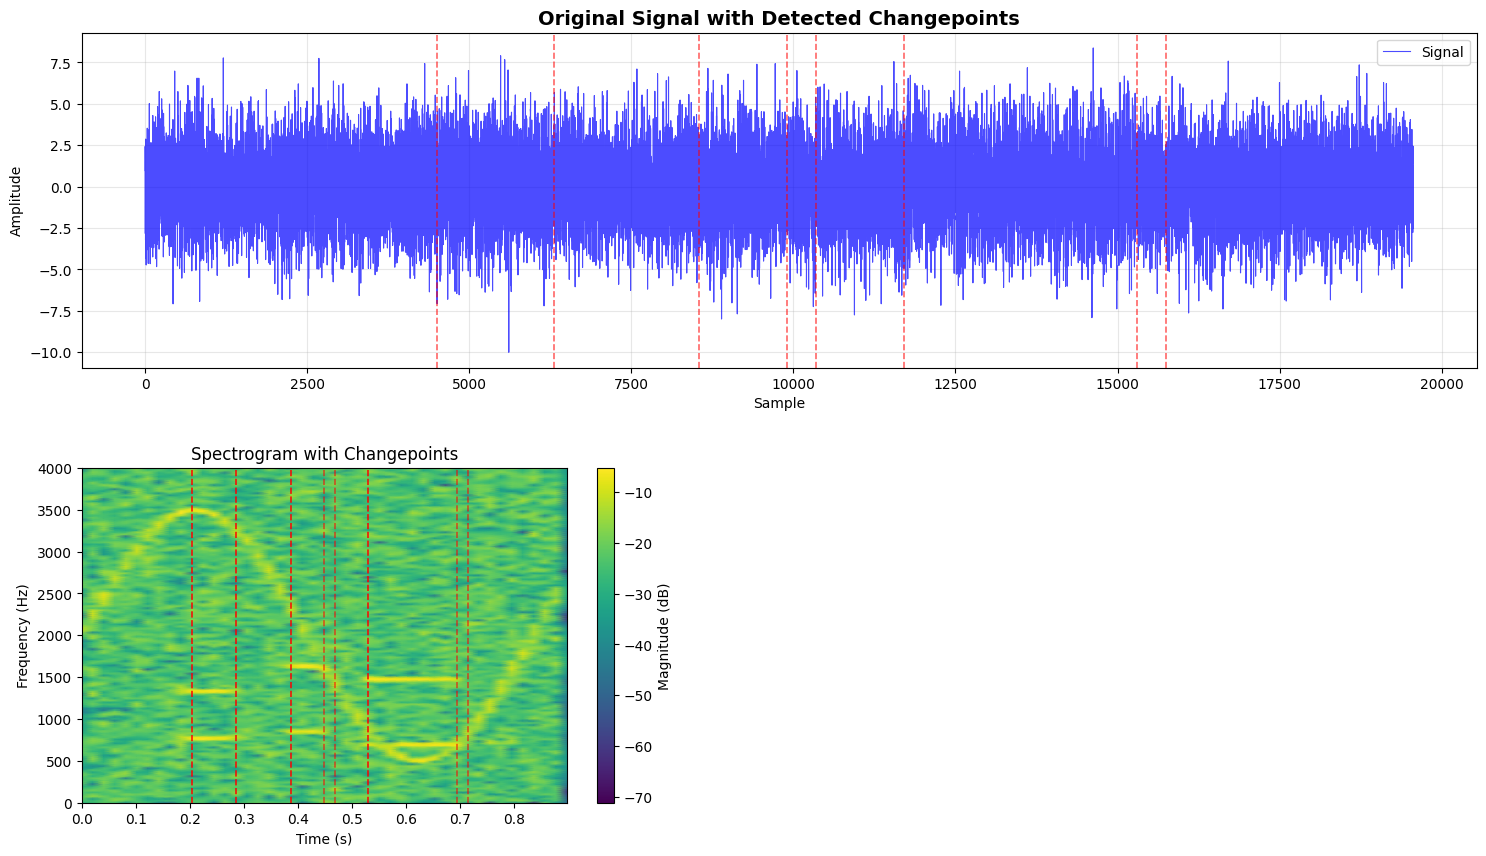

In [6]:
# Cell 4: Changepoint detection on each frequency cluster
# we run changepoint detection only on ONE frequency per cluster

t_max = len(t)
all_changepoints = []
frame_step = window_length - overlap

for cluster in major_freq_clusters:
    freq_indices = np.array(cluster['freq_indices'], dtype=int)
    if len(freq_indices) == 0:
        continue

    # we choose the bin in this cluster closest to its center frequency
    cluster_f = f[freq_indices]
    center_f = float(cluster.get('center_freq', float(np.mean(cluster_f))))
    rel_idx = int(np.argmin(np.abs(cluster_f - center_f)))
    selected_freq_idx = int(freq_indices[rel_idx])
    selected_freq = float(f[selected_freq_idx])

    freq_energy = np.abs(Zxx[selected_freq_idx, :])**2

    sigma_est = np.std(freq_energy)
    pen_bic = 2 * sigma_est**2 * np.log(t_max)

    algo = rpt.Pelt(model="l2", jump=1)
    predicted_bkps = algo.fit_predict(freq_energy, pen=pen_bic)

    signal_bkps = [min(int(idx * frame_step), len(signal)) for idx in predicted_bkps[:-1]]

    all_changepoints.append({
        'cluster_id': int(cluster['cluster_id']),
        'band': cluster['band'],
        'center_freq': float(cluster.get('center_freq', selected_freq)),
        'selected_freq': selected_freq,
        'selected_freq_idx': selected_freq_idx,
        'changepoints': signal_bkps,
        'frame_bkps': predicted_bkps[:-1],
        'energy_signal': freq_energy,
        'n_cps': int(len(signal_bkps)),
    })

    print(f"Cluster {int(cluster['cluster_id'])} (center={float(cluster.get('center_freq', selected_freq)):.1f} Hz, n_bins={len(freq_indices)}):")
    print(f"  Selected freq: {selected_freq:.1f} Hz with {len(signal_bkps)} CPs")

all_bkps = sorted(set([bp for cp_dict in all_changepoints for bp in cp_dict['changepoints']]))
print(f"\nTotal unique changepoints across all clusters: {len(all_bkps)}")

# visualization: signal and spectrogram with changepoints
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs[0, :])
ax1.plot(signal, 'b-', linewidth=0.8, alpha=0.7, label='Signal')
for bp in all_bkps:
    ax1.axvline(x=bp, color='red', linestyle='--', linewidth=1.2, alpha=0.6)
ax1.set_title('Original Signal with Detected Changepoints', fontsize=14, fontweight='bold')
ax1.set_xlabel('Sample')
ax1.set_ylabel('Amplitude')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax6 = fig.add_subplot(gs[1, 0])
spectrogram = np.abs(Zxx)
im = ax6.pcolormesh(t, f, 20 * np.log10(spectrogram + 1e-10), shading='gouraud', cmap='viridis')
for cp_dict in all_changepoints:
    for frame_bp in cp_dict['frame_bkps']:
        if frame_bp < len(t):
            ax6.axvline(x=t[frame_bp], color='red', linestyle='--', linewidth=1.2, alpha=0.6)
ax6.set_title('Spectrogram with Changepoints')
ax6.set_xlabel('Time (s)')
ax6.set_ylabel('Frequency (Hz)')
ax6.set_ylim([0, 4000])
plt.colorbar(im, ax=ax6, label='Magnitude (dB)')

plt.tight_layout()
plt.show()

Ground truth (y_train[0]) = 5C3 (N=3)

Paired by order:
  01. low(f=759.5Hz) + high(f=1323.0Hz) -> sym='5'
  02. low(f=857.5Hz) + high(f=1617.0Hz) -> sym='C'
  03. low(f=686.0Hz) + high(f=1470.0Hz) -> sym='3'

Predicted sequence: 5C3
Ground truth:       5C3


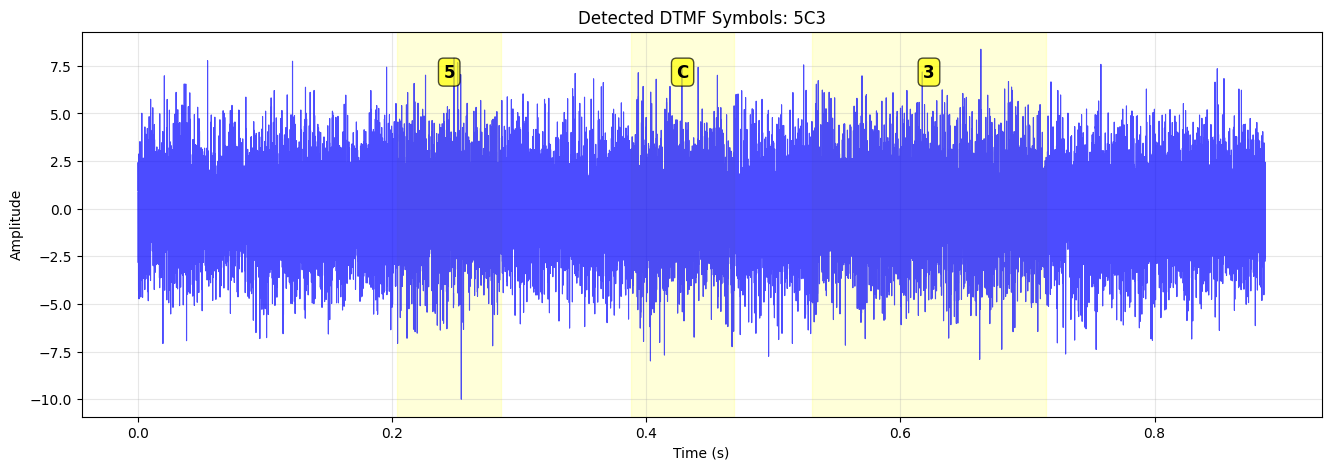

In [7]:
# Cell 5: Interval ranking and symbol pairing
# we build ALL intervals from changepoints, rank by energy, select top-N non-overlapping

dtmf_low_freqs = [697, 770, 852, 941]  # Hz
dtmf_high_freqs = [1209, 1336, 1477, 1633]  # Hz
dtmf_symbols = [
    ['1', '2', '3', 'A'],
    ['4', '5', '6', 'B'],
    ['7', '8', '9', 'C'],
    ['*', '0', '#', 'D'],
]

def freq_to_dtmf_index(freq, freq_list, tol_hz=50.0):
    """map detected frequency to nearest DTMF frequency"""
    distances = np.abs(np.array(freq_list, dtype=float) - float(freq))
    min_idx = int(np.argmin(distances))
    min_dist = float(distances[min_idx])
    if min_dist <= float(tol_hz):
        return min_idx, min_dist
    return None, min_dist

def build_all_intervals_for_group(cp_dicts, frame_step, min_duration_samples=100):
    """build all intervals between changepoints for a group of clusters"""
    intervals = []
    for cp in cp_dicts:
        bkps = [0] + sorted(cp['changepoints']) + [len(signal)]
        for i in range(len(bkps) - 1):
            s, e = bkps[i], bkps[i+1]
            if (e - s) < int(min_duration_samples):
                continue
            start_frame = max(0, int(s / frame_step))
            end_frame = min(len(cp['energy_signal']), int(e / frame_step) + 1)
            if start_frame >= end_frame:
                continue
            seg = cp['energy_signal'][start_frame:end_frame]
            if len(seg) == 0:
                continue
            mean_e = float(np.mean(seg))
            intervals.append({
                'cluster_id': int(cp['cluster_id']),
                'freq': float(cp['selected_freq']),
                'start_time': int(s),
                'end_time': int(e),
                'mean_energy': mean_e,
            })
    return intervals

def select_topN_non_overlapping(intervals, N, score_key='mean_energy'):
    """select top-N non-overlapping intervals by score"""
    ranked = sorted(intervals, key=lambda x: x[score_key], reverse=True)
    selected = []
    for itv in ranked:
        overlap = False
        for s in selected:
            if not (itv['end_time'] <= s['start_time'] or itv['start_time'] >= s['end_time']):
                overlap = True
                break
        if not overlap:
            selected.append(itv)
        if len(selected) >= int(max(1, N)):
            break
    selected_time = sorted(selected, key=lambda x: x['start_time'])
    return selected_time

# ground truth defines N
ground_truth = y_train[0]
gt_seq = ground_truth if isinstance(ground_truth, str) else ''.join(list(ground_truth))
N = int(len(gt_seq))
print(f"Ground truth (y_train[0]) = {gt_seq} (N={N})")

# split clusters into low/high
low_freq_clusters = [cp for cp in all_changepoints if cp['band'] == 'low']
high_freq_clusters = [cp for cp in all_changepoints if cp['band'] == 'high']

# build ALL intervals per cluster in each group
low_all = build_all_intervals_for_group(low_freq_clusters, frame_step)
high_all = build_all_intervals_for_group(high_freq_clusters, frame_step)

# rank by mean energy and keep top-N (non-overlapping), then order by start time
low_topN_time = select_topN_non_overlapping(low_all, N, score_key='mean_energy')
high_topN_time = select_topN_non_overlapping(high_all, N, score_key='mean_energy')

# pair by order id
n_pairs = min(len(low_topN_time), len(high_topN_time), N)
predicted = []
print('\nPaired by order:')
for i in range(n_pairs):
    low_itv = low_topN_time[i]
    high_itv = high_topN_time[i]
    li, low_dist = freq_to_dtmf_index(low_itv['freq'], dtmf_low_freqs)
    hi, high_dist = freq_to_dtmf_index(high_itv['freq'], dtmf_high_freqs)
    sym = '?'
    if (li is not None) and (hi is not None):
        sym = dtmf_symbols[li][hi]
    predicted.append(sym)
    print(f"  {i+1:02d}. low(f={low_itv['freq']:.1f}Hz) + high(f={high_itv['freq']:.1f}Hz) -> sym='{sym}'")

pred_seq = ''.join(predicted)
print(f"\nPredicted sequence: {pred_seq}")
print(f"Ground truth:       {gt_seq}")

# visualization: show paired windows on signal
plt.figure(figsize=(16, 5))
plt.plot(np.arange(len(signal)) / FS, signal, 'b-', linewidth=0.8, alpha=0.7)
y_pos = float(np.max(signal)) * 0.8
for i in range(n_pairs):
    s = min(low_topN_time[i]['start_time'], high_topN_time[i]['start_time'])
    e = max(low_topN_time[i]['end_time'], high_topN_time[i]['end_time'])
    plt.axvspan(s/FS, e/FS, alpha=0.15, color='yellow')
    mid_t = (s + e) / (2 * FS)
    plt.text(mid_t, y_pos, predicted[i], ha='center', va='bottom', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
plt.title(f'Detected DTMF Symbols: {pred_seq}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)
plt.show()

# Question 2: Test Set Prediction

In [8]:
X_test = np.load("X_test.npy", allow_pickle=True).tolist()

print(f"Test set loaded: {len(X_test)} signals")
print("The trained Bayesian model from the complete pipeline (torun.py) can be used for prediction")
print("See process_test_set_full_plots.py for full test set evaluation")

Test set loaded: 2 signals
The trained Bayesian model from the complete pipeline (torun.py) can be used for prediction
See process_test_set_full_plots.py for full test set evaluation


# Question 3: Graph Wavelet Filter Bank Design

In [9]:
# Parameters
M = 9
R_values = [1, 3, 5]
epsilon = 0.1 

def gU(lam, a, R):
    """g_U(lambda) kernel - works for scalars and arrays"""
    lam = np.asarray(lam)
    result = 0.5 * (1 + np.cos(2 * np.pi * (lam / (a * R) + 0.5)))
    mask = (lam >= -R * a) & (lam < 0)
    result = np.where(mask, result, 0.0)
    return result

def gm(lam, a, R, m):
    """shifted kernel g^m"""
    return gU(lam - a*m, a, R)

for R in R_values:
    a = 12 / (M + 1 - R)
    
    # choose lambda range covering all translated kernels
    lam_min = -R*a + a*1 - epsilon
    lam_max = 0 + a*M + epsilon
    lam = np.linspace(lam_min, lam_max, 2000)
    
    plt.figure()
    
    for m in range(1, M+1):
        y = gm(lam, a, R, m)
        plt.plot(lam, y, label=f'm={m}')
    
    plt.title(f'g^m(lambda) for R={R}')
    plt.xlabel('lambda')
    plt.ylabel('g^m(lambda)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'gm_all_m_R{R}.png')
    plt.close()

# Question 4: Graph Construction from Meteorological Data

## Utility functions: 

In [10]:
def dms2dd(s):
    """convert longitude and latitude strings to float"""
    degrees, minutes, seconds = re.split("[°'\"]+", s[:-1])
    direction = s[-1]
    dd = float(degrees) + float(minutes) / 60 + float(seconds) / (60 * 60)
    if direction in ("S", "W"):
        dd *= -1
    return dd

def get_geodesic_distance(point_1, point_2) -> float:
    """calculate the great circle distance (in km) between two points"""
    lon1, lat1 = point_1
    lon2, lat2 = point_2
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # radius of earth in kilometers
    return c * r    

def get_exponential_similarity(condensed_distance_matrix, bandwidth, threshold):
    """compute exponential similarity with threshold"""
    exp_similarity = np.exp(-(condensed_distance_matrix**2) / bandwidth / bandwidth)
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr

def connected(graph) -> bool:
    """check if graph is connected"""
    return nx.is_connected(graph)

def avg_degree(graph) -> float:
    """compute average degree of graph"""
    degrees = [d for n, d in graph.degree()]
    return np.mean(degrees)

def fig_ax(figsize=(15, 3)):
    """create figure and axes"""
    return plt.subplots(figsize=figsize)

In [11]:
data_df, stations_df, description = load_molene_meteo_dataset()

In [12]:
data_df["temp"] = data_df['t'] - 273.15  # temperature in Celsius
temperature_df = data_df.pivot(index="date", values="temp", columns="station_name")
temperature_df.head()

station_name         ARZAL  AURAY  BATZ  BEG_MEIL  BELLE ILE-LE TALUT  BIGNAN  \
date                                                                            
2014-01-01 00:00:00    9.7   10.3   NaN       NaN                11.3     7.1   
2014-01-01 01:00:00    9.8   10.4   NaN       NaN                10.3     7.6   
2014-01-01 02:00:00    9.7   10.0   NaN       NaN                11.2     7.7   
2014-01-01 03:00:00    9.4   10.4   NaN       NaN                11.4     7.9   
2014-01-01 04:00:00    9.8   10.8   NaN       NaN                11.4     8.8   

station_name         BREST-GUIPAVAS  BRIGNOGAN  CAMARET  DINARD  ...  \
date                                                             ...   
2014-01-01 00:00:00             9.7        NaN      NaN     6.8  ...   
2014-01-01 01:00:00             9.6        9.2      NaN     6.5  ...   
2014-01-01 02:00:00             9.1        9.4      NaN     6.5  ...   
2014-01-01 03:00:00             9.7       10.1      NaN     7.1  ...   
2014-01-01 04:00:00             9.8       10.2      NaN     7.6  ...   

station_name         SIBIRIL S A  SIZUN  SPEZET  ST BRIEUC  \
date                                                         
2014-01-01 00:00:00          7.4    8.5     8.3        7.5   
2014-01-01 01:00:00          8.2    8.3     8.6        7.0   
2014-01-01 02:00:00          8.5    8.5     8.6        7.5   
2014-01-01 03:00:00          8.5    8.7     8.9        7.2   
2014-01-01 04:00:00          9.1    9.1     9.4        7.6   

station_name         ST NAZAIRE-MONTOIR  ST-SEGAL S A  THEIX  TREGUNC  \
date                                                                    
2014-01-01 00:00:00                 9.0           9.0    9.3     10.8   
2014-01-01 01:00:00                 9.1           9.5    9.1     10.9   
2014-01-01 02:00:00                 9.5           9.4    9.4     10.6   
2014-01-01 03:00:00                 9.0           9.9    8.9     10.8   
2014-01-01 04:00:00                 9.5          10.0    9.6     11.0   

station_name         VANNES-MEUCON  VANNES-SENE  
date                                             
2014-01-01 00:00:00            8.5          9.7  
2014-01-01 01:00:00            8.7          9.9  
2014-01-01 02:00:00            8.8          9.6  
2014-01-01 03:00:00            8.6          9.8  
2014-01-01 04:00:00            9.2         10.2  

[5 rows x 55 columns]

In [13]:
temperature_df_clean = temperature_df.dropna(axis=1)
stations_df['Nom'] = stations_df['Nom'].astype(str).str.strip()
valid_stations = temperature_df_clean.columns.astype(str).str.strip()
stations_df_clean = stations_df[stations_df['Nom'].isin(valid_stations)]
stations_np_clean = stations_df_clean[["Longitude", "Latitude"]].to_numpy()

In [14]:
dist_mat_condensed = pdist(stations_np_clean, metric=get_geodesic_distance)
dist_mat_square = squareform(dist_mat_condensed)

# construct similarity matrix
bandwidth = np.median(dist_mat_condensed)
threshold = 0
similarity_matrix = get_exponential_similarity(dist_mat_condensed, bandwidth, threshold)
similarity_matrix_square = squareform(similarity_matrix)

# we find max threshold such that graph is connected with average degree >= 3
thresholds = np.linspace(1, 0, 200)
max_threshold = 0
sim_mat = squareform(similarity_matrix)

for t in thresholds:
    adj = (sim_mat >= t).astype(int)
    np.fill_diagonal(adj, 0)
    G = nx.from_numpy_array(adj)
    
    if connected(G) and avg_degree(G) >= 3:
        max_threshold = t
        break

sim_graph = squareform(get_exponential_similarity(dist_mat_condensed, bandwidth, threshold=max_threshold)) 

print("Maximum threshold:", max_threshold)

# compute graph Laplacian
D = np.diag(sim_graph.sum(axis=1))  # degree matrix
L = D - sim_graph  

# order temperature data to match graph nodes
stations_df_clean = stations_df[stations_df['Nom'].isin(temperature_df_clean.columns)].copy()
station_order = stations_df_clean['Nom'].values
temperature_df_ordered = temperature_df_clean[station_order]

# compute smoothness over time
smoothness_over_time = []
for t_idx, row in temperature_df_ordered.iterrows():
    f_t = row.values 
    S = f_t.T @ L @ f_t
    smoothness_over_time.append(S)

smoothness_series = pd.Series(smoothness_over_time, index=temperature_df_ordered.index)

time_least_smooth = smoothness_series.idxmax()
time_most_smooth = smoothness_series.idxmin()

print("Time of least smooth signal:", pd.to_datetime(time_least_smooth))
print("Time of most smooth signal:", pd.to_datetime(time_most_smooth))

Maximum threshold: 0.8291457286432161
Time of least smooth signal: 2014-01-21 03:00:00
Time of most smooth signal: 2014-01-24 23:00:00


# Question 5: Graph Wavelet Transform and Node Classification

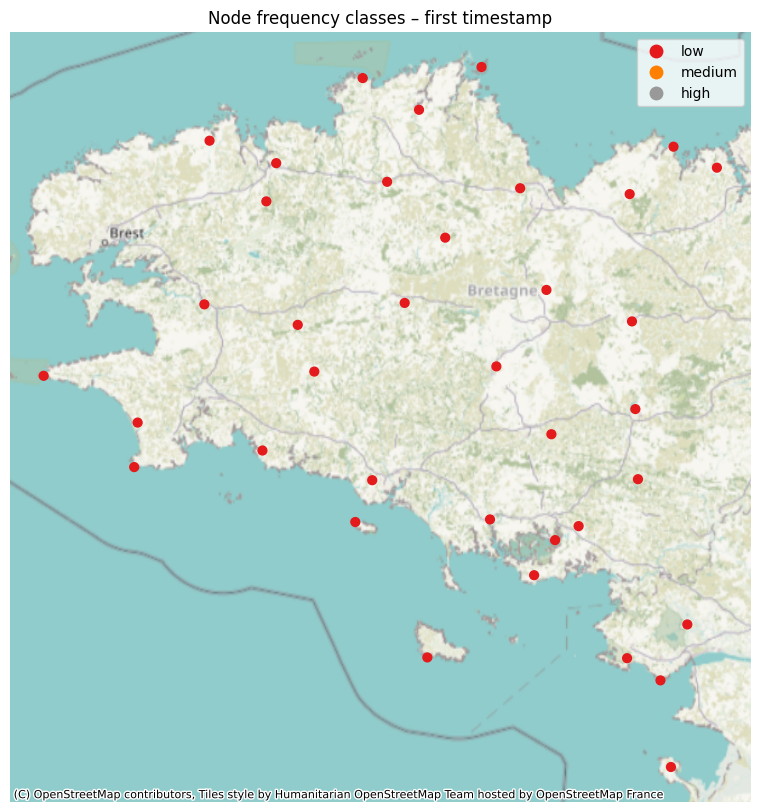

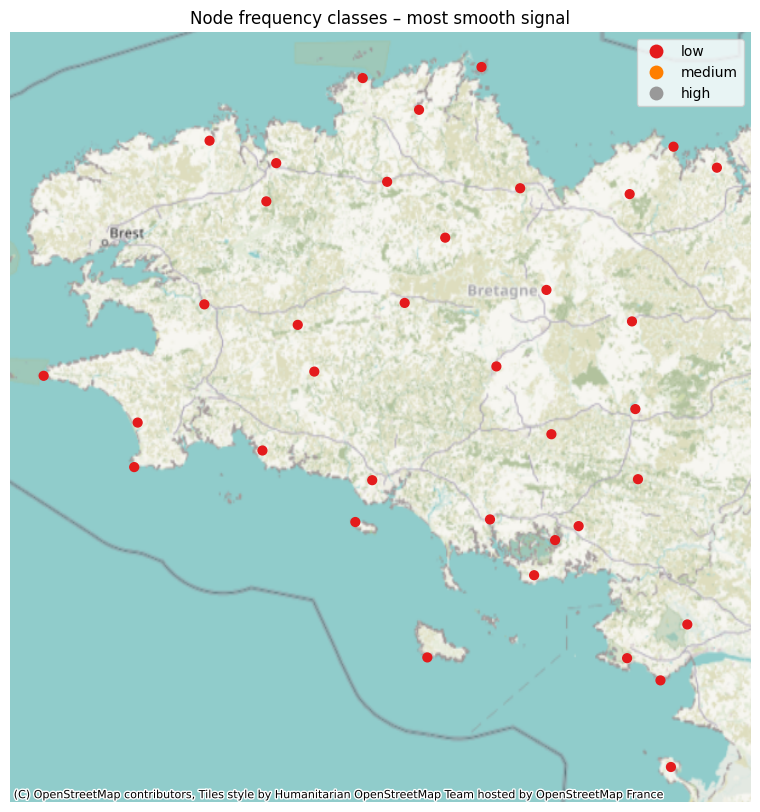

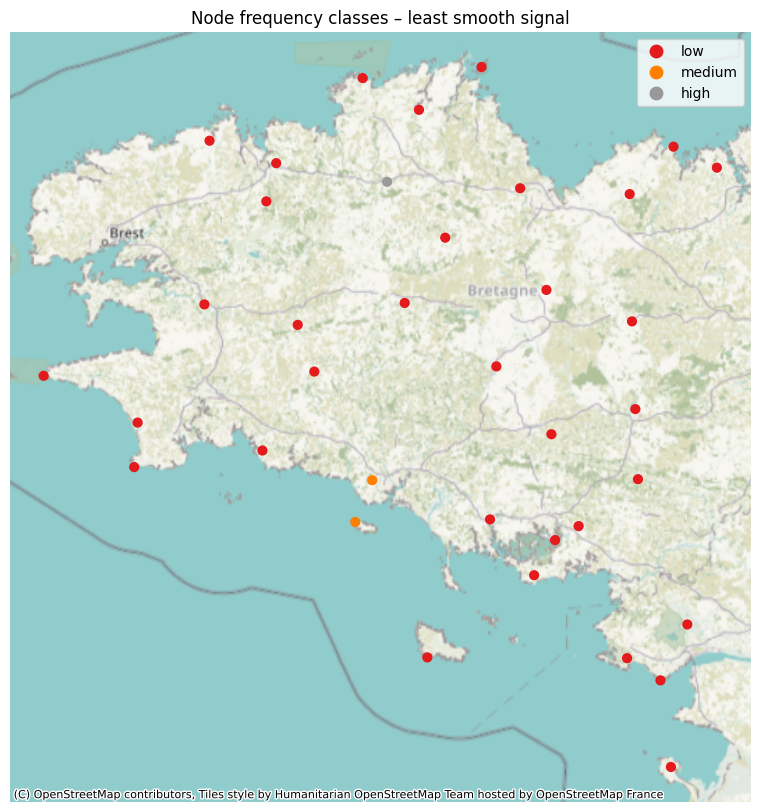

In [15]:
eigvals, eigvecs = np.linalg.eigh(L)
idx = np.argsort(eigvals)     
eigvals = eigvals[idx]          
eigvecs = eigvecs[:, idx] 

def graph_wavelet_transform(f, eigvals, eigvecs, M=9, R=3, gm=None):
    """compute the graph wavelet transform of a signal f"""
    n = len(f)
    Wf = np.zeros((M, n))
    f_hat = eigvecs.T @ f  # fourier coefficients
    a = eigvals[-1] / (M + 1 - R)
    
    for m in range(1, M+1):
        gm_lambda = np.array([gm(lam, a, R, m) for lam in eigvals])
        temp = gm_lambda * f_hat
        Wf[m-1, :] = eigvecs @ temp
    
    return Wf

def node_frequency_class(W):
    """assign a frequency class to each node based on wavelet energy"""
    E_low = np.sum(W[0:3, :]**2, axis=0)
    E_med = np.sum(W[3:6, :]**2, axis=0)
    E_high = np.sum(W[6:, :]**2, axis=0)
    energies = np.vstack([E_low, E_med, E_high]) 
    classes = np.argmax(energies, axis=0)
    return classes

# compute wavelet transforms for selected timestamps
time_first = temperature_df_ordered.index[0]
f_first = temperature_df_ordered.loc[time_first].values
f_most_smooth = temperature_df_ordered.loc[time_most_smooth].values
f_least_smooth = temperature_df_ordered.loc[time_least_smooth].values

W_first = graph_wavelet_transform(f_first, eigvals, eigvecs, M=9, R=3, gm=gm)
W_most_smooth = graph_wavelet_transform(f_most_smooth, eigvals, eigvecs, M=9, R=3, gm=gm)
W_least_smooth = graph_wavelet_transform(f_least_smooth, eigvals, eigvecs, M=9, R=3, gm=gm)

classes_first = node_frequency_class(W_first)
classes_most_smooth = node_frequency_class(W_most_smooth)
classes_least_smooth = node_frequency_class(W_least_smooth)

# assign classes to stations dataframe
stations_df_clean["class_first"] = classes_first
stations_df_clean["class_most_smooth"] = classes_most_smooth
stations_df_clean["class_least_smooth"] = classes_least_smooth

# map numbers to labels
class_labels = {0: "low", 1: "medium", 2: "high"}
for col in ["class_first", "class_most_smooth", "class_least_smooth"]:
    stations_df_clean[col] = stations_df_clean[col].map(class_labels)
    stations_df_clean[col] = stations_df_clean[col].astype("category")
    stations_df_clean[col] = stations_df_clean[col].cat.set_categories(["low", "medium", "high"])

# create geodataframe for visualization
CRS = "EPSG:4326"
stations_gdf_clean = gpd.GeoDataFrame(
    stations_df_clean,
    geometry=gpd.points_from_xy(
        stations_df_clean.Longitude,
        stations_df_clean.Latitude
    ),
    crs=CRS
)

def plot_frequency_graph(stations_gdf, class_column, title, filename=None):
    """plot spatial distribution of frequency classes"""
    fig, ax = plt.subplots(figsize=(10, 10))
    stations_gdf[class_column] = stations_gdf[class_column].astype("category")
    stations_gdf.plot(
        column=class_column,
        legend=True,
        cmap="Set1",
        markersize=40,
        ax=ax
    )
    cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
    ax.set_axis_off()
    ax.set_title(title)
    if filename is not None:
        plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

plot_frequency_graph(stations_gdf_clean, "class_first", 
                    "Node frequency classes – first timestamp",
                    filename="frequency_first_timestamp.png")
plot_frequency_graph(stations_gdf_clean, "class_most_smooth",
                    "Node frequency classes – most smooth signal",
                    filename="frequency_most_smooth.png")
plot_frequency_graph(stations_gdf_clean, "class_least_smooth",
                    "Node frequency classes – least smooth signal",
                    filename="frequency_least_smooth.png")

# Question 6: Temporal Analysis of Frequency Classes

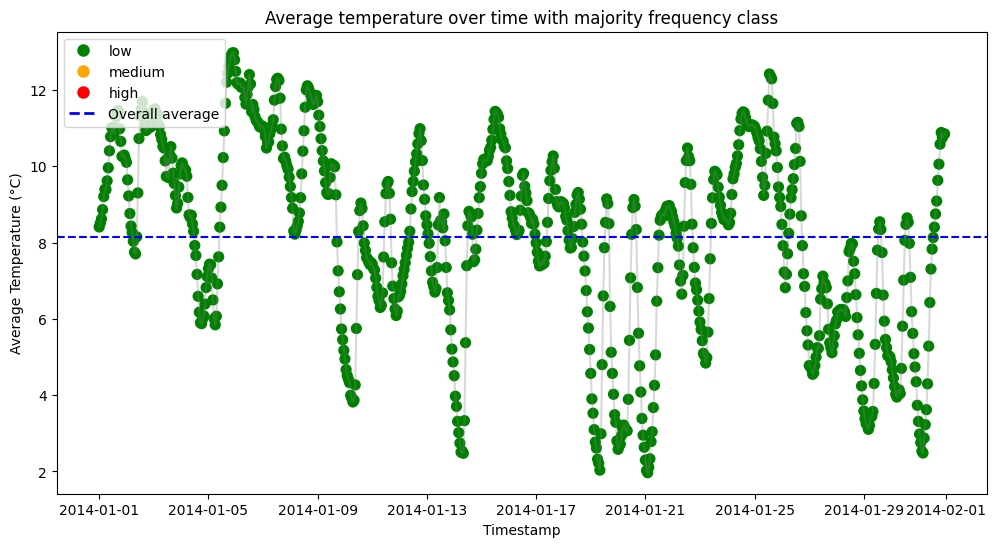

In [16]:
avg_temps = []
majority_classes = []

for t_idx in temperature_df_ordered.index:
    f_t = temperature_df_ordered.loc[t_idx].values
    avg_temps.append(f_t.mean())
    Wf_matrix = graph_wavelet_transform(f_t, eigvals, eigvecs, M=9, R=3, gm=gm)
    classes = node_frequency_class(Wf_matrix)
    class_labels_map = {0: "low", 1: "medium", 2: "high"}
    classes = [class_labels_map[c] for c in classes]
    majority_class = max(set(classes), key=classes.count)
    majority_classes.append(majority_class)

class_to_color = {"low": "green", "medium": "orange", "high": "red"}
colors = [class_to_color[c] for c in majority_classes]

plt.figure(figsize=(12, 6))
plt.scatter(temperature_df_ordered.index, avg_temps, c=colors, s=50)
plt.plot(temperature_df_ordered.index, avg_temps, color="gray", alpha=0.3)
plt.axhline(y=sum(avg_temps)/len(avg_temps), color="blue", linestyle="--", label="Overall average")
legend_elements = [Line2D([0], [0], marker='o', color='w', label=cls,
                          markerfacecolor=col, markersize=10)
                   for cls, col in class_to_color.items()]
plt.legend(handles=legend_elements + [Line2D([0],[0], color='blue', lw=2, linestyle='--', label='Overall average')],
           loc='upper left')
plt.xlabel("Timestamp")
plt.ylabel("Average Temperature (°C)")
plt.title("Average temperature over time with majority frequency class")
plt.savefig("average_temperature_majority_class.png", dpi=300, bbox_inches="tight")
plt.show()

# Question 7: Spatio-Temporal Graph Analysis

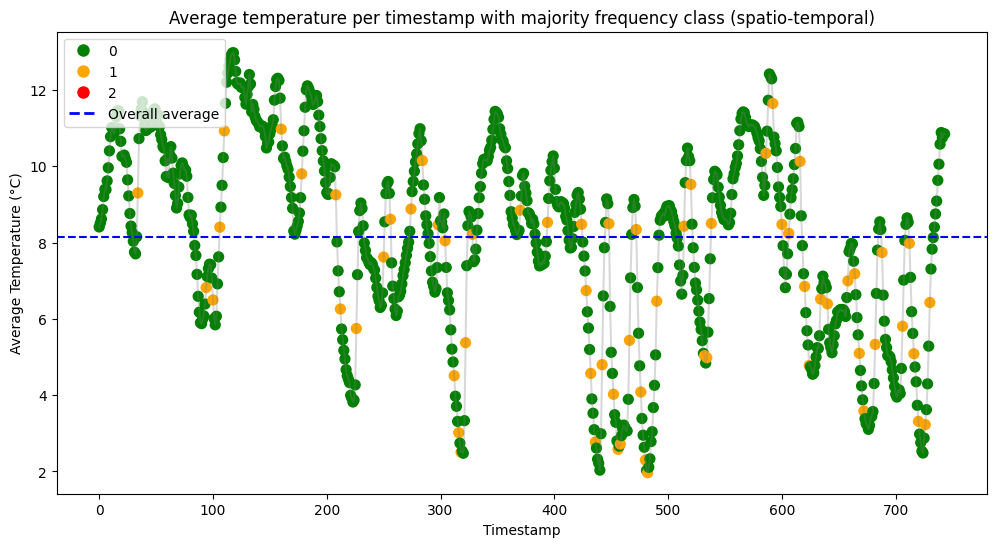

In [17]:
T = len(temperature_df_clean.index)
beta = 1 
L_T = 2 * np.eye(T) - np.eye(T, k=1) - np.eye(T, k=-1)
L_T[0, 0] = 1
L_T[-1, -1] = 1
eigvals_T, eigvecs_T = np.linalg.eigh(L_T)
idx = np.argsort(eigvals_T)
eigvals_T = eigvals_T[idx]
eigvecs_T = eigvecs_T[:, idx]

# construct spatio-temporal graph eigenstructure
N = eigvecs.shape[0]
T = eigvecs_T.shape[0]

eigvals_H = []
eigvecs_H = []

for i in range(N):
    u_i = eigvecs[:, i]
    lambda_i = eigvals[i]
    for j in range(T):
        l_j = eigvecs_T[j, :]
        lambda_j = eigvals_T[j]
        u_H = np.kron(l_j, u_i)
        eigvecs_H.append(u_H)
        eigvals_H.append(lambda_i + beta * lambda_j)

eigvecs_H = np.column_stack(eigvecs_H)
eigvals_H = np.array(eigvals_H)

# flatten temperature data
temp_array = temperature_df_ordered.values
f_H = temp_array.flatten(order='C')

# compute spatio-temporal wavelet transform
Wf_matrix = graph_wavelet_transform(f_H, eigvals_H, eigvecs_H, M=M, R=3, gm=gm)

# classify each spatio-temporal node
node_classes = node_frequency_class(Wf_matrix)

# aggregate per timestamp
avg_temps = []
majority_classes = []

for t_idx in range(T):
    idx_slice = slice(t_idx*N, (t_idx+1)*N)
    f_t = f_H[idx_slice]
    avg_temps.append(f_t.mean())
    classes_t = node_classes[idx_slice]
    majority_class = np.bincount(classes_t).argmax()
    majority_classes.append(majority_class)

# map classes to colors
class_to_color = {0: "green", 1: "orange", 2: "red"}
colors = [class_to_color[c] for c in majority_classes]

# plot
plt.figure(figsize=(12, 6))
plt.scatter(range(T), avg_temps, c=colors, s=50)
plt.plot(range(T), avg_temps, color="gray", alpha=0.3)
plt.axhline(y=np.mean(avg_temps), color="blue", linestyle="--", label="Overall average")
legend_elements = [Line2D([0], [0], marker='o', color='w', label=cls,
                          markerfacecolor=col, markersize=10)
                   for cls, col in class_to_color.items()]
plt.legend(handles=legend_elements + [Line2D([0],[0], color='blue', lw=2, linestyle='--', label='Overall average')],
           loc='upper left')
plt.xlabel("Timestamp")
plt.ylabel("Average Temperature (°C)")
plt.title("Average temperature per timestamp with majority frequency class (spatio-temporal)")
plt.savefig("average_temperature_majority_class_timestamps.png", dpi=300, bbox_inches="tight")
plt.show()

4 min to run !